# Model separation power

The goal of this notebook is to see the separation power of the matchbox net model.

In order to do so, we will use UMAP to project the data on a smaller manifold in order to see the separation. Using that we will compare : 
- The original manifold of the data
- The manifold of the data passed through the model

In [1]:
import torch
from dataset import SpeechCommandsData
from transforms import Scattering
from models import EncDecBaseModel
import umap
import pathlib
import umap.plot
import numpy as np
from tqdm import tqdm

%matplotlib inline
umap.plot.output_notebook()

2023-05-17 17:20:12.754310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

## Utils

In [19]:
@torch.no_grad()
def extract_logits(model, dataloader):
  logits_buffer = []
  label_buffer = []

  for batch in tqdm(dataloader):
    audio_signal, labels = batch
  
    logits_buffer.append(model(audio_signal.squeeze()))
    label_buffer.append(labels)
  
  logits = torch.cat(logits_buffer, 0)
  labels = torch.cat(label_buffer, 0)
  return logits, labels

In [3]:
def speech_commands_collate(batch):
    """Collate function for setting up the dataloader

    Args:
        batch (int): batch size

    Returns:
        batch: return batched data in the form ; tensors,targets
    """
    tensors, targets, t_labels = [], [], []
    for waveform, label, rate, sid, uid in batch:
        if isinstance(waveform,np.ndarray):
            tensors += [torch.from_numpy(waveform)]
        elif isinstance(waveform, torch.Tensor):
            tensors += [waveform]
        else:
            raise ValueError("Waveform must be saved as torch.tensor or np.array")
        targets += [torch.tensor(label)]

    tensors = [item.t() for item in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(
        tensors, batch_first=True, padding_value=0.0
    )
    
    targets = torch.stack(targets)

    return tensors, targets

## UMAP

We use the `umap` library along with the `umap.plot` to calculate the manifolds and plot them.

We first start by importing the models

In [4]:
device = torch.device("cpu")

#Load model
PATH='../models/sep.pt'
model = torch.nn.Sequential( Scattering(),EncDecBaseModel(num_mels=50,num_classes=35,final_filter=128,input_length=1000))
model.load_state_dict(torch.load(PATH))
model.to(device)

model.eval()

identity=torch.nn.Identity() # we use the identity function for it to be compatible with the extract logits function

We then load the dataset

In [5]:
labels_names = ["backward","bed","bird","cat","dog","down","eight","five","follow","forward","four","go","happy","house","learn","left","marvin","nine","no","off","on","one","right","seven","sheila","six","stop","three","tree","two","up","visual","wow","yes","zero"]

# Set the path to your dataset
root = pathlib.Path("../dataset/")

# Load your dataset into PyTorch using the SpeechCommandsData class
train_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="training")
test_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="testing")

# Create PyTorch data loaders for your dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)

We then extract the data. We chose to take the output of the encoder in our model.

In [20]:
model_logits,model_labels=extract_logits(lambda x : (model[1].encoder(model[0](x),model[1].input_length))[0],test_loader)
original_data,original_labels=extract_logits(identity,test_loader)

100%|██████████| 86/86 [00:02<00:00, 42.54it/s]


Finally we calculate the manifolds and plot

In [21]:
manifold = umap.UMAP().fit(model_logits.flatten(1),model_labels)
original_manifold = umap.UMAP().fit(original_data.flatten(1),original_labels)

Here is the manifold of the data passed through the model:

<Axes: >

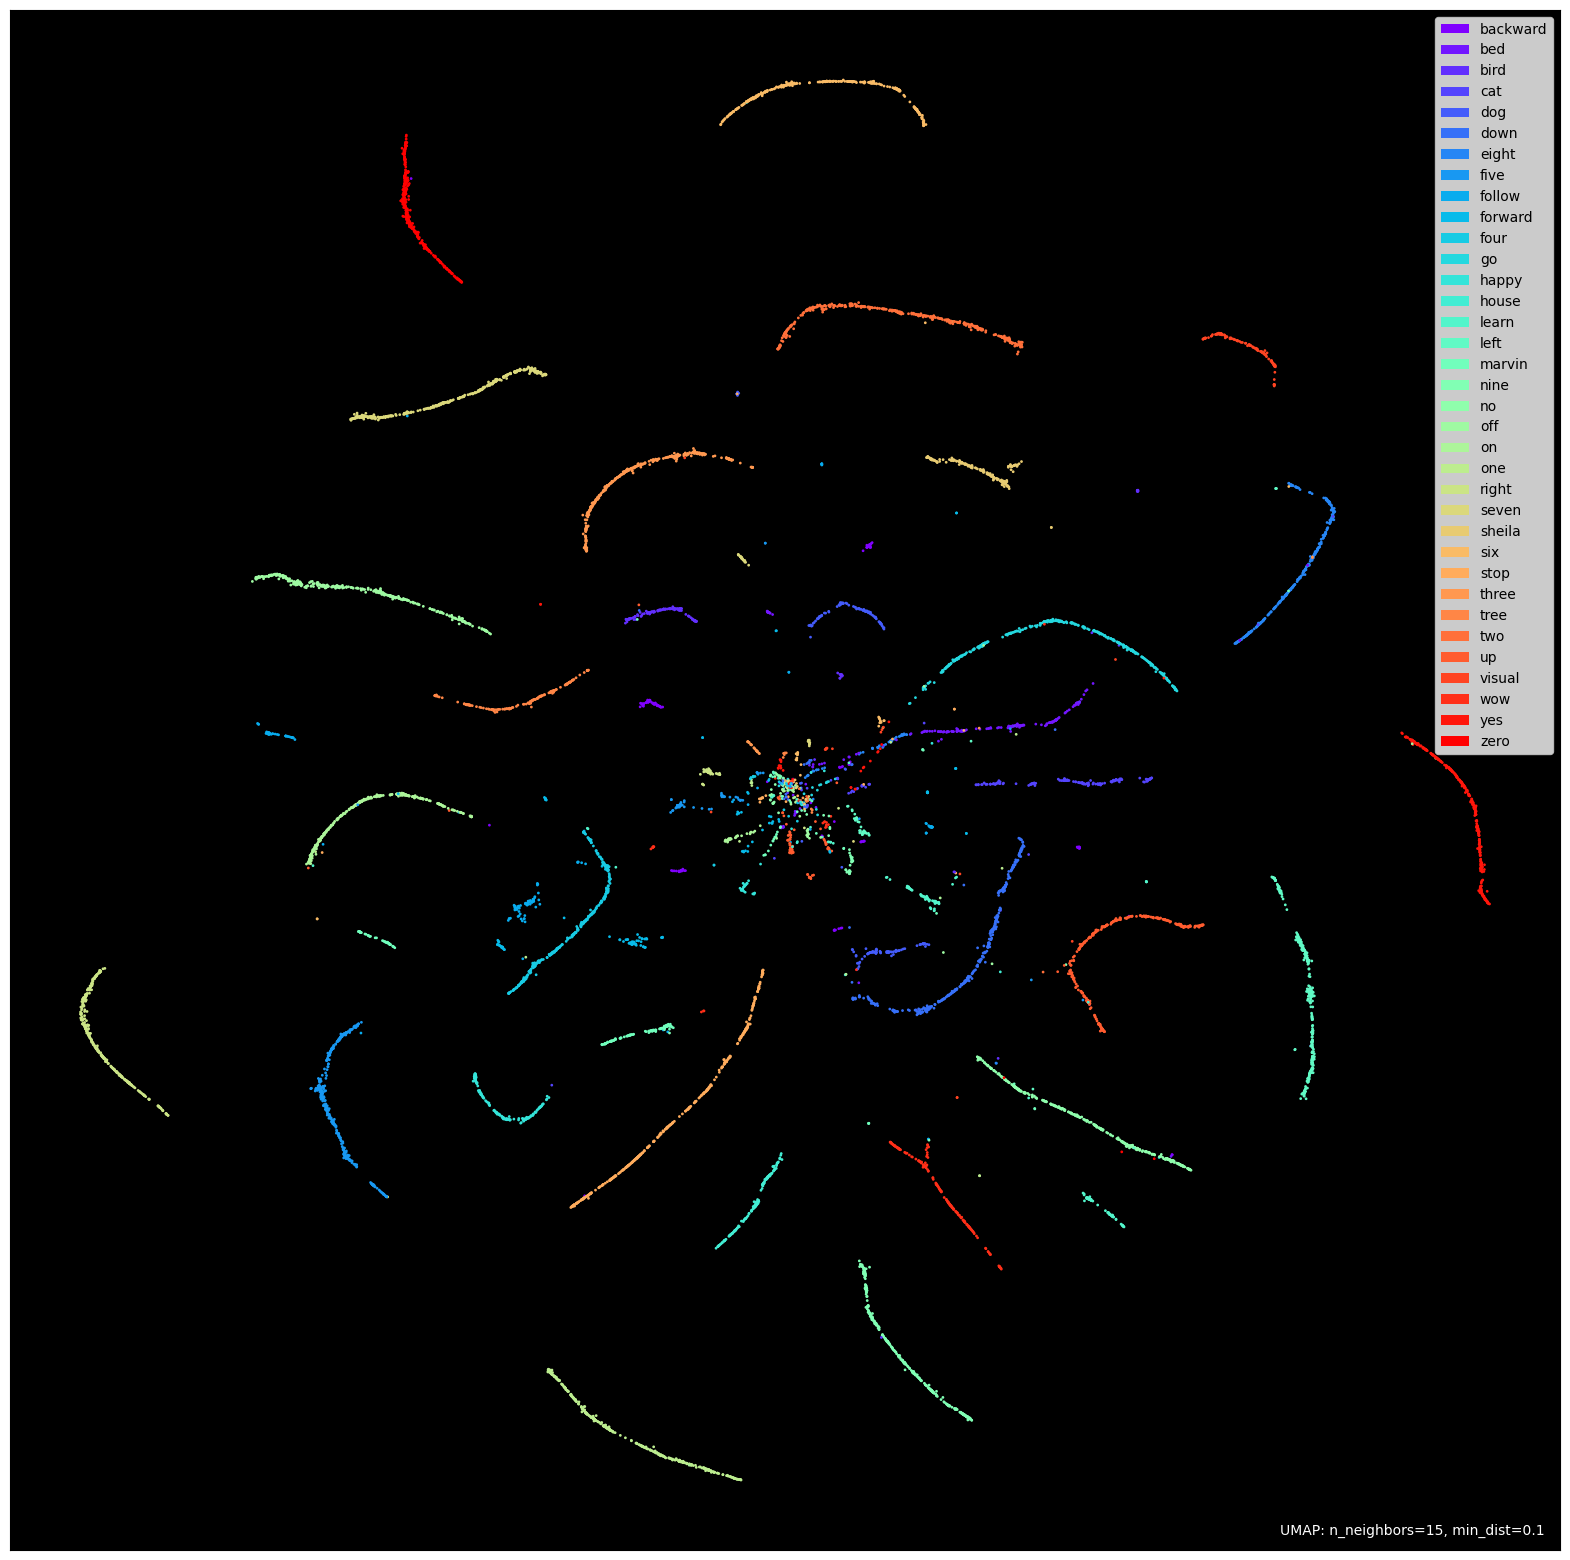

In [22]:
umap.plot.points(manifold, labels=np.array([labels_names[i] for i in model_labels]),width=2000,height=2000,theme="fire")

And here is the manifold of the original wav data:

<Axes: >

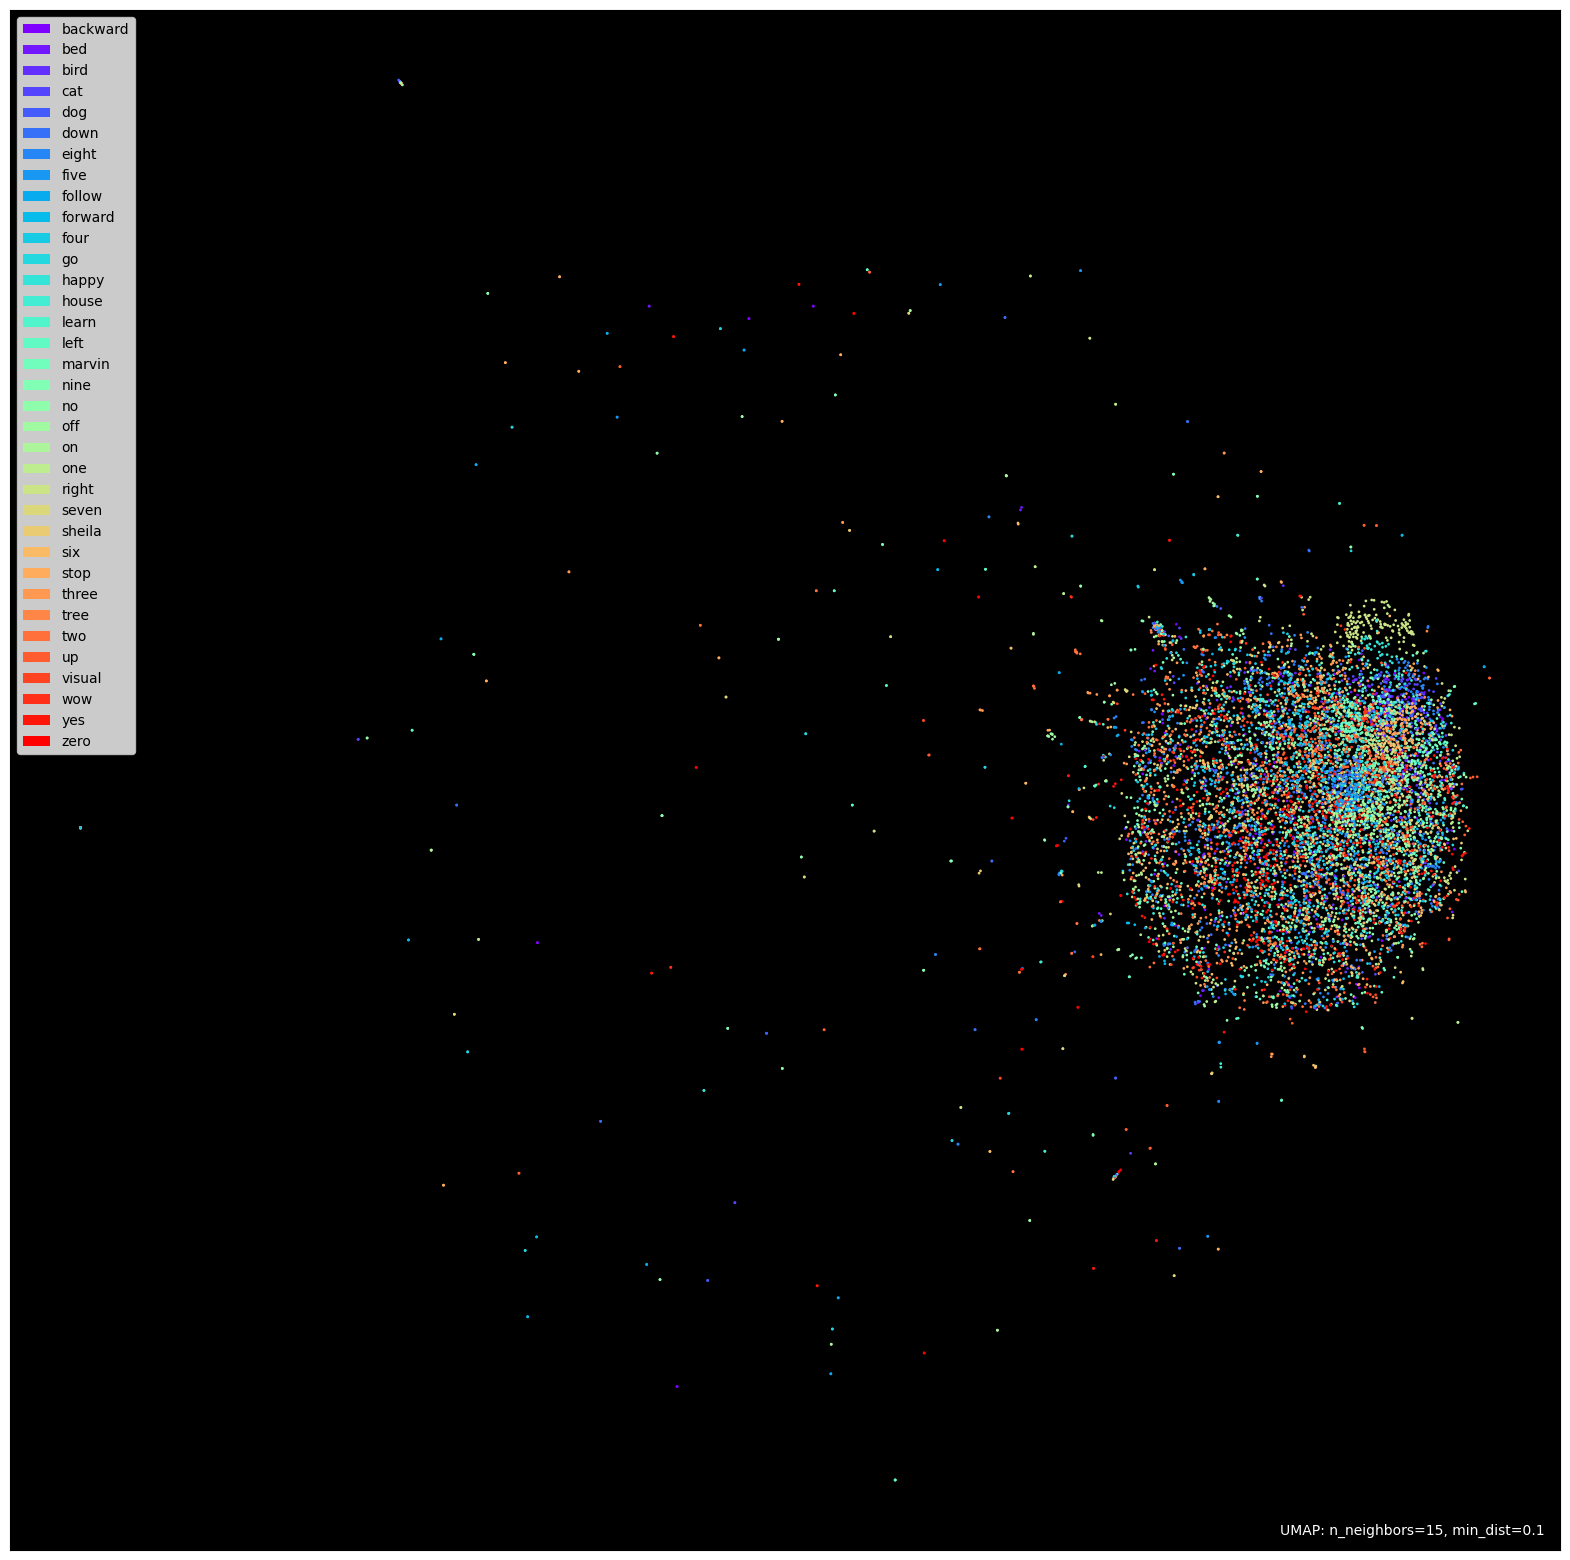

In [23]:
umap.plot.points(original_manifold, labels=np.array([labels_names[i] for i in original_labels]),width=2000,height=2000,theme="fire")

As we can see our model has a great separation capability and is able to differentiate most of the classes